# Model Training

The EDA on our raw dataset showed we need to take some few simple steps to get it ready for modelling. We will start with those steps before getting on with building our multiclass classifier.

## 1.0 Import Libraries
The relevant libraries are imported. There are some nltk downloads that are only required when running this notebook for the first time. Subsequents runs do not require these downloads.

In [1]:
import os

import warnings
warnings.filterwarnings('ignore')

import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix

import config 

import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import StrMethodFormatter

import pickle

import pipeline_config as pc
import model_training_utils as mtu



## 2.0 Preparing the data
The dataset is loaded from the file. The duplicates in the dataset are dropped, the names of the colums and the categories in the target column are modified for convenience. The name of one of the states and one of the categories that used an incorrect letter case were modified to reflect the correct case. Though it was not done during the EDA because it was not affecting the analysis, the descriptions of the complaints were sliced to remove the comments from FCC (a regulatory body).

In [2]:
#loading the dataset
print ('loading dataset...')
data = pd.read_csv('datasets/ComCast_FCC.csv')

loading dataset...


In [3]:
#dropping the duplicates in the dataset
primary_data = mtu.PrepareData(data).drop_duplicates()

In [4]:
#modifying the dataset
primary_data = mtu.PrepareData(primary_data).modify()

In [5]:
# split the descriptions on the dashes to extract the comments from FCC
primary_data = mtu.PrepareData(primary_data).extract()

## 3.0 Modelling

### Train Test Split
The train test split was doing using the scikit learn standard test train split function. The train set size is 80%. Since the modelling will use gridsearchCV to find the best parameters, a validation set was not absolutely necessary so it was not factored in the split. The target variable is the 'category' column, the other features are the input variables.


In [6]:
#input and target variables
input_features = primary_data.drop(columns = 'category')
y = primary_data.category

In [7]:
#size of the variables
input_features.shape, y.shape

((2208, 7), (2208,))

We need only the 'description' column of the input features, the other features will not be useful for model training so we will extract only the relevant column for model training.

In [8]:
#train test split
input_features_train, input_features_test, y_train, y_test = train_test_split(input_features, y, test_size=0.2, random_state=16)
X_train = input_features_train.description
X_test = input_features_test.description
X_train.shape, X_test.shape, y_train.shape, y_test.shape,

((1766,), (442,), (1766,), (442,))

### Model Training and Evaluation
The classifiers used in the modelling include:
-   Dummy Classifier: used to establish the base case
-   MultinimialNB, MNB
-   Randomforest, RFC
-   SupportVectorMachine, SVM
-   ExtraTreeClassifier, XTC
-   GradientBoostingClassifier, GBC
-   BaggingClassifier, BGC
-   XGBClassifier, XGB
-   LogisticRegression, LGR

The gridsearchCV was only done on the XGB and the LGR. The best parameters for each algorithm are used to train a model and the model with the best f1 score is chosen as the best performing model.

The metrics for evaluation are accuracy, weighted f1 score and macro f1 score.

The models will be trained with feature extraction processes from scikit learn - CountVectorizer and TF-idf. There will be two batches of model training. First will be with CountVectorizer and TF-idf, the next will have some feature engineering from the nltk library.

In [9]:
#default parameters
model_metrics = mtu.model_metrics(pc.CLASSIFIERS, X_train, X_test, y_train, y_test)
model_metrics

,classifier,accuracy,micro_f1,weighted_f1,macro_f1
0,dummy,0.386878,0.386878,0.215844,0.111582
1,MNB,0.488688,0.488688,0.389033,0.290649
2,BGC,0.619910,0.619910,0.604388,0.573869
3,XTC,0.660633,0.660633,0.632979,0.602372
4,RFC,0.683258,0.683258,0.656779,0.629311
5,SVM,0.696833,0.696833,0.692081,0.656526
6,GBC,0.703620,0.703620,0.694426,0.667811
7,XGB,0.719457,0.719457,0.711486,0.683836
8,LGR,0.737557,0.737557,0.724880,0.684095


The gridsearch CV is applied to XGB and LGR to find the best parameters. These parameters are then used to train models and their performances measured aginst the performance of the model with default parameters.

Note: It takes a LONG time running these gridsearchCV.

In [10]:
#grid search XGB pipeline
# parameters = pc.XGB_PARAMETERS

# cv = pc.CV

# gs_xgb_clf = GridSearchCV(pc.XGB_CLF, parameters, cv=cv, verbose=True)

# gs_xgb_clf.fit(X_train, y_train)

# # gs_svm_clf_pred = gs_svm_clf.predict(X_test)

# best_parameters = gs_xgb_clf.best_estimator_.get_params()
# for param_name in sorted(parameters.keys()):
#         print("\t%s: %r" % (param_name, best_parameters[param_name]))

In [11]:
#define a XGB pipeline using result from grid search
from xgboost import XGBClassifier
xgb_clf_grid = Pipeline([
                ('vect', CountVectorizer(ngram_range = (1, 1))),
                ('tfidf', TfidfTransformer(use_idf = True)), 
                ('clf', XGBClassifier(n_estimators= 150,
                subsample= 0.9,
                gamma= 0.25,
                learning_rate= 0.20, 
                max_depth= 6,
                objective='logistic'))
])

#fit XGB pipeline
xgb_clf_grid.fit(X_train, y_train)

#evaluate XGB pipeline
xgb_pipeline_pred_grid  = xgb_clf_grid.predict(X_test)
acc_score_xgb_grid_pipeline = accuracy_score(y_test, xgb_pipeline_pred_grid )
F1_score_macro_xgb_grid_pipeline = f1_score(y_test, xgb_pipeline_pred_grid, average = 'macro')
print(acc_score_xgb_grid_pipeline, F1_score_macro_xgb_grid_pipeline)

0.7036199095022625 0.6698145154199431


In [12]:
#grid search LGR pipeline
# parameters = pc.LGR_PARAMETERS

# cv = pc.CV

# gs_lgr_clf = GridSearchCV(pc.LGR_CLF, parameters, cv=cv, verbose=True)

# gs_lgr_clf.fit(X_train, y_train)

# # gs_xtc_clf_pred = gs_xtc_clf.predict(X_test)

# best_parameters = gs_lgr_clf.best_estimator_.get_params()
# for param_name in sorted(parameters.keys()):
#         print("\t%s: %r" % (param_name, best_parameters[param_name]))

In [13]:
#define a LGR pipeline using result from grid search
lgr_clf_grid = Pipeline([
        ('vect', CountVectorizer(ngram_range = (1, 1))),
        ('tfidf', TfidfTransformer(use_idf = True)),
         ('clf', LogisticRegression(multi_class = 'multinomial',
                                max_iter = 200,
                                penalty = 'l2',)),
])

#fit LGR pipeline
lgr_clf_grid.fit(X_train, y_train)

#evaluate LGR pipeline
lgr_pipeline_pred_grid  = lgr_clf_grid.predict(X_test)
acc_score_lgr_grid_pipeline = accuracy_score(y_test, lgr_pipeline_pred_grid )
F1_score_macro_lgr_grid_pipeline = f1_score(y_test, lgr_pipeline_pred_grid, average = 'macro')
print(acc_score_lgr_grid_pipeline, F1_score_macro_lgr_grid_pipeline)

0.7375565610859729 0.6840948368206813


The results from training the models with the best parameters indicate that the models with default parameters have a better performance. Going forward the models will be trained on default parameters.

### NLTK
Let's use the nltk library to build the model with the hope of achieving a better model performance. We tokenize, remove stopwords, and lemmatize the input variables. Then we use a pipeline to train and fit a model.

In [14]:
#define a XGB pipeline using result from grid search
xgb_clf_nltk = Pipeline([
            ('text', pc.PROCESS_TEXT),
          ('vect', CountVectorizer(ngram_range = (1, 1))),
        ('tfidf', TfidfTransformer(use_idf = True)),
         ('clf', XGBClassifier()),
])

xgb_clf_nltk.fit(X_train, y_train)

xgb_nltk_pipeline_pred = xgb_clf_nltk.predict(X_test)
acc_score_xgb_nltk_pipeline = accuracy_score(y_test, xgb_nltk_pipeline_pred)
F1_score_micro_xgb_nltk_pipeline = f1_score(y_test, xgb_nltk_pipeline_pred, average = 'micro')
F1_score_weighted_xgb_nltk_pipeline = f1_score(y_test, xgb_nltk_pipeline_pred, average = 'weighted')
F1_score_macro_xgb_nltk_pipeline = f1_score(y_test, xgb_nltk_pipeline_pred, average = 'macro')
metrics_xgb_nltk = ['XGB_nltk', acc_score_xgb_nltk_pipeline, F1_score_micro_xgb_nltk_pipeline, 
                    F1_score_weighted_xgb_nltk_pipeline, F1_score_macro_xgb_nltk_pipeline]
print(metrics_xgb_nltk)

In [ ]:
#LGR pipeline using result from grid search
lgr_clf_nltk = Pipeline([
        ('text', pc.PROCESS_TEXT),
        ('vect', CountVectorizer()),
        ('tfidf', TfidfTransformer()),
         ('clf', LogisticRegression()),
])

lgr_clf_nltk.fit(X_train, y_train)

lgr_clf_nltk_pred = lgr_clf_nltk.predict(X_test)
acc_score_lgr_nltk_pipeline = accuracy_score(y_test, lgr_clf_nltk_pred)
F1_score_micro_lgr_nltk_pipeline = f1_score(y_test, lgr_clf_nltk_pred, average = 'micro')
F1_score_weighted_lgr_nltk_pipeline = f1_score(y_test, lgr_clf_nltk_pred, average = 'weighted')
F1_score_macro_lgr_nltk_pipeline = f1_score(y_test, lgr_clf_nltk_pred, average = 'macro')
metrics_lgr_nltk = ['LGR_nltk', acc_score_lgr_nltk_pipeline, F1_score_micro_lgr_nltk_pipeline, 
                    F1_score_weighted_lgr_nltk_pipeline, F1_score_macro_lgr_nltk_pipeline]
print(metrics_lgr_nltk)

['LGR_nltk', 0.7420814479638009, 0.7420814479638009, 0.7323978758774842, 0.7002275106881226]


The performance for the models using the nltk library did not show any significant improvement in model performance when compared against the initial models.

In [ ]:
model_metrics.loc[len(model_metrics.index)] = metrics_xgb_nltk
model_metrics.loc[len(model_metrics.index)] = metrics_lgr_nltk
model_metrics

,classifier,accuracy,micro_f1,weighted_f1,macro_f1
0,dummy,0.386878,0.386878,0.215844,0.111582
1,MNB,0.488688,0.488688,0.389033,0.290649
2,BGC,0.619910,0.619910,0.604388,0.573869
3,XTC,0.660633,0.660633,0.632979,0.602372
4,RFC,0.683258,0.683258,0.656779,0.629311
5,SVM,0.696833,0.696833,0.692081,0.656526
6,GBC,0.703620,0.703620,0.694426,0.667811
7,XGB,0.719457,0.719457,0.711486,0.683836
8,LGR,0.737557,0.737557,0.724880,0.684095
9,XGB_nltk,0.721719,0.721719,0.715893,0.692618


## Journey Map
A plot of the model performances of the various models.

<function matplotlib.pyplot.show(close=None, block=None)>

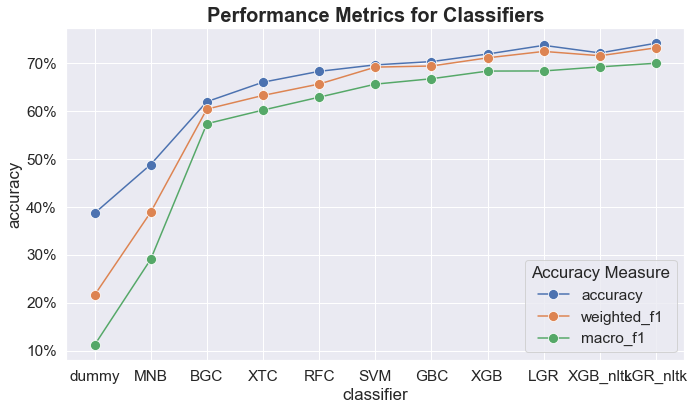

In [ ]:
plt.figure(figsize=(10,6))
metrics = ['accuracy', 'weighted_f1', 'macro_f1']
for metric in metrics:
    sns.lineplot(data=model_metrics,
        x='classifier',  y=metric,
        marker='o', markersize=10,
    )
plt.gcf().axes[0].yaxis.set_major_formatter(StrMethodFormatter('{x:.0%}'))
plt.legend(title='Accuracy Measure', labels = metrics, loc='lower right')
plt.savefig('readme_plots/Performance Metrics for Classifiers')
plt.title('Performance Metrics for Classifiers', fontsize=20, fontweight='bold')
plt.tight_layout()
plt.show

## 4.0 Model Selection

LogisticRegression shows the best performance on the three evaluation metrics so it is selected as the best model. Since the nltk did not bring any significant improvement in model performance as did the best parameters from the gridsearchCV results, the LGR model will be trained on default parameters and the sk-learn feature extraction.

The model is saved as a pickle file and can be loaded for making predictions on new customer complaints.

In [ ]:
#train selected model
model = pc.LGR_CLF
model.fit(X_train, y_train)

Pipeline(steps=[('vect', CountVectorizer()), ('tfidf', TfidfTransformer()),
                ('clf', LogisticRegression(random_state=1607))])

In [ ]:
#save model as a pickle file
with open('lgr_model.pkl', 'wb') as file:
     pickle.dump(model, file)

## 5.0 Model Evaluation
Use classification report and confusion matrix to show the model performance of our selected model.

In [ ]:
#load model from pickle file
with open('lgr_model.pkl', 'rb') as file:
    loaded_model = pickle.load(file)

In [ ]:
#use loaded model to make predictions
predictions = loaded_model.predict(X_test)

In [ ]:
target_names = ['Billings', 'Internet Problems', 'Poor Customer Service', 'Data Caps', 'Other']
print(classification_report(y_test, predictions, target_names=target_names))

                       precision    recall  f1-score   support

             Billings       0.72      0.88      0.79       171
    Internet Problems       0.79      0.81      0.80       124
Poor Customer Service       0.64      0.44      0.52        79
            Data Caps       0.72      0.81      0.76        36
                Other       1.00      0.38      0.55        32

             accuracy                           0.74       442
            macro avg       0.77      0.66      0.68       442
         weighted avg       0.75      0.74      0.72       442



<function matplotlib.pyplot.show(close=None, block=None)>

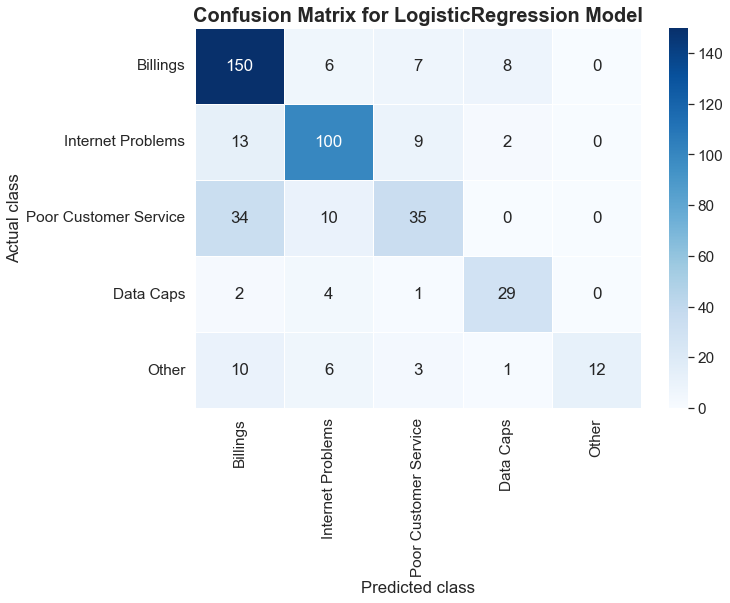

In [ ]:
#confusion matrix plot
data = confusion_matrix(y_test, predictions)
df_cm = pd.DataFrame(data, columns=target_names, index = target_names)
df_cm.index.name = 'Actual class'
df_cm.columns.name = 'Predicted class'
sns.set(font_scale=1.4)
fig, ax = plt.subplots(figsize=(10,7))
plt.title('Confusion Matrix for LogisticRegression Model', fontsize=20, fontweight='bold')
sns.heatmap(df_cm, cmap='Blues', linewidths=1, annot=True, ax=ax, fmt='g')
plt.savefig('readme_plots/Confusion Matrix for LogisticRegression Model')
plt.show

## 6.0 Dashboard
The predictions are merged to the corresponding input variables. The outcome can be saved into a csv file and used to create a dashboard.

In [ ]:
#merge predictions to the corresponding input variables
predictions_df = pd.DataFrame(input_features_test)
predictions_df['predictions'] = predictions

In [ ]:
#the category column needs to be converted to its original values
predictions_df['predictions'] = predictions_df['predictions'].replace(
                            [0, 1, 2, 3, 4], 
                            ['Billings', 'Internet Problems', 'Poor Customer Service', 'Data Caps', 'Other'])
predictions_df.reset_index(drop = True)

,customer_complaint,date,city,state,zip_code,description,fcc_comments,predictions
0,Comcast Internet,2015-06-07,Charleston,South Carolina,48230,Our house has not one but two comcast internet...,\n Follow-up message by FCC on 6/8/2015 3:50:3...,Internet Problems
1,Comcast slamming/overcharge/,2015-04-27,Happy Valley,Oregon,97086,I recently moved and had comcast transfer serv...,\n Follow-up message by FCC on 4/30/2015 4:07:...,Billings
2,Comcast Very Bad /Rude customer service,2015-04-22,Johns Creek,Georgia,30097,I am having comcast internet service in Johns ...,\n Follow-up message by FCC on 4/23/2015 7:28:...,Billings
3,Comcast Complaint,2015-04-21,Jacksonville,Florida,32207,Postal Mail Ticket Ready For Data Entry\n,\n Follow-up message by FCC on 5/28/2015 1:51:...,Other
4,Unable to fully use services and high bills,2015-05-01,Indianapolis,Indiana,46229,My bill has been unusually high lately and hav...,None,Billings
...,...,...,...,...,...,...,...,...
437,Comcast Internet Data Cap LIES,2015-06-30,Cartersville,Georgia,30121,I live in an area where Comcast is our only op...,\n Follow-up message by FCC on 7/9/2015 3:06:5...,Data Caps
438,"Sold one service, received another",2015-06-11,Northport,Alabama,35473,I was sold a 150mbps speed with no data allowa...,\n Follow-up message by FCC on 6/12/2015 2:08:...,Billings
439,Comcast: Billing issue,2015-04-27,Washington,District Of Columbia,20002,This is a complaint about Comcast Cable and In...,\n Follow-up message by FCC on 4/29/2015 7:01:...,Billings
440,Comcast Blocking UDP Port 443,2015-06-05,Arlington,Virginia,22206,I work for the federal government and am the C...,\n Follow-up message by Consumer on 6/9/2015 1...,Internet Problems


In [ ]:
#save dataframe to a csv file
predictions_df.to_csv ('datasets/predictions.csv',  index = False, header=True)

Use the csv file to create the interactive dashboard below. The dashboard can be applied too monitoring the trend of complaints from customers. The trend can be monitored in a state or a group of states over a period of time. The different categories can be investigated indivually or in groups.

 <img src="image_files\power_BI_report_page.jpg" width=1000 height=600 />

## 7.0 Conclusion

The model is saved in a pickle file. It can be incorporated in a micro service that can be used remotely.

## 8.0 Deployment

Let's see how a user will put this model to work. We will use our test data from our model evaluation to trial the model in a web service. We will write the test input features back to a csv file and work our way up from there.

In [ ]:
test_input = pd.DataFrame(input_features_test)
#save dataframe to a csv file
test_input.to_csv ('datasets/test_input.csv', index = False, header=True)

We will demonstrate here that we can take a csv file containing customer complaints and go through the process of making the predictions. The predictions are appended to the file and returned as a csv file. The returned csv file can be processed in the dashboard or analysed with some other analytical tools to find some patterns to the complaints from customers.

In [ ]:
#read the csv file, load the model and make predictions
test_input = pd.read_csv('datasets/test_input.csv')
test_input = pd.DataFrame(test_input)
test_input_variables = test_input['description']
#load model
with open('lgr_model.pkl', 'rb') as file:
        model = pickle.load(file)
#make predictions
predictions = model.predict(test_input_variables)
#append the predictions to the input dataframe
test_input['predictions'] = predictions
#map the categories back to their categorical equivalents
test_input['predictions'] = test_input['predictions'].replace(
                            [0, 1, 2, 3, 4], 
                            ['Billings', 'Internet Problems', 'Poor Customer Service', 'Data Caps', 'Other'])
test_input.reset_index(drop=True)
#save the dataframe as a csv file
filepath = 'datasets/predictions.csv'
test_input.to_csv (filepath, index = False, header=True)

There are several possible reports that can be generated from the returned csv file. The plot below shows the counts of the various categories in the predictions made by the model for the period of time the complaints were collected. It also shows the changes in the amount of complaints received over the period of time under review.

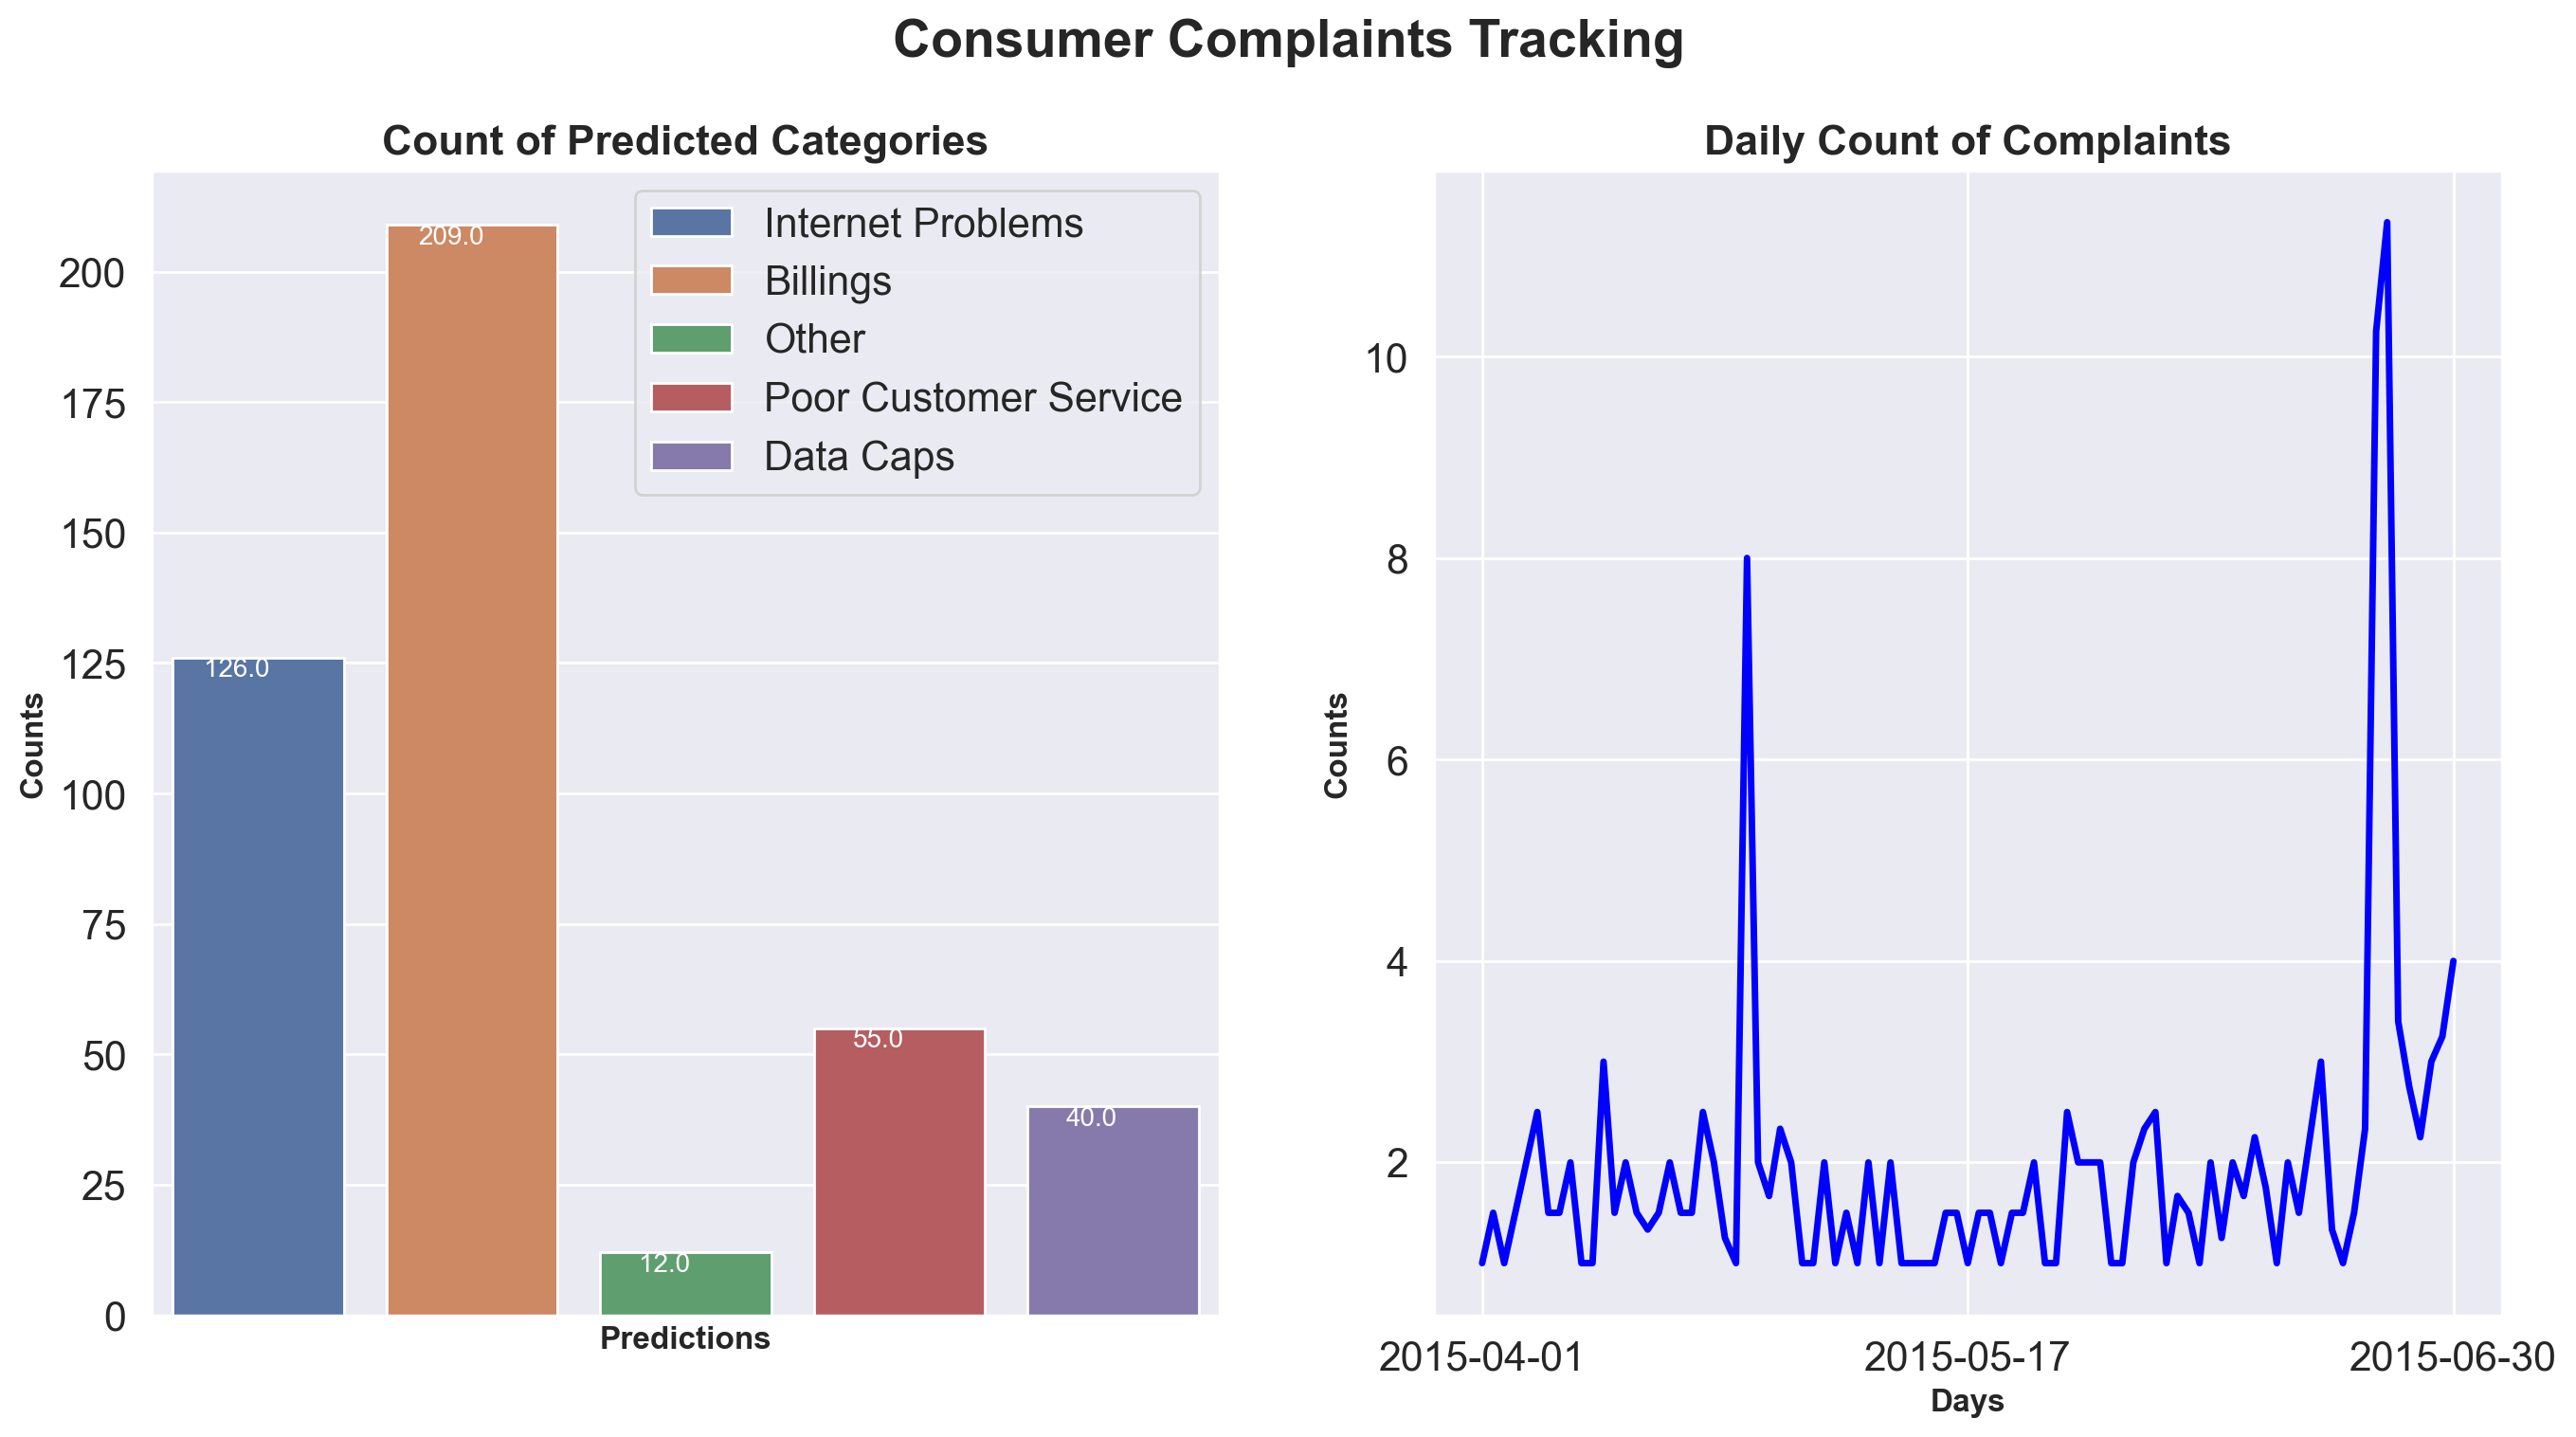

In [ ]:
mtu.deploy_plot('datasets/predictions.csv')

## Model Application
We have seen how to take customer complaints, use a machine learning model to automate the classification of these complaints and how to put the model to work in the field. This model can be used by various functional units in an organisation. Let's go through some of the applications of this model.

-   The automation of complaints will free up time for customer service staff to take care of other tasks
-   Sales representatives will be able to identify services in their market area that customers are mostly not happy with
-   The operations team can monitor how their maintenance services are reducing the technical challenges customers are experiencing
-   The The operations team can also use the knowledge from the distribution of the complaints in the country to plan deployment of resources for maintenance projects
-   Leadership can monitor the volume of complaints from customers and take actions to avoid fines from regulatory authorities.